In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
# Llegim el nom dels nodes.
# Obrim el fitxer '.txt' i  llegim les linies.
with open('mindboggle_ROIs_class.txt', 'r') as file:
    header_line = file.readline().strip()

    data = []

    for line in file:
        values = line.strip().split('\t')
        data.append(values)

dict_data = dict()
for i in data:
    node=int(i[0])-1
    dict_data[str(node)] = i[1]
#dict_data

In [3]:
# Read CSV File.
df = pd.read_csv('clinic_data_oversampled.csv')
df.head()


,Unnamed: 0,Unnamed: 0.1,id,redcap_event_name,controls_ms,dob,msonset,nrldate,age,sex,...,assortativity_m,betweenness_centrality_m,global_efficiency_m,local_efficiency_m,transitivity_m,modularity_m,matrix,corrected_matrix_functional,corrected_matrix_structural,corrected_matrix_morphological
0,0,0.0,002MSVIS,year3_arm_1,1,1963-09-04,1993-01-10,2015-03-16,51.53,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 0.32851901 0.37493742 -0.39139019 ... 0.52...,[ 0.39740076 -0.09341676 0. ... 0.34...,[0.00977906 0.0100095 0.00361605 ... 0.018132...
1,1,1.0,003MSVIS,year5_arm_1,1,1959-01-18,2007-07-15,2017-02-08,58.06,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[-0.31202184 0.08207223 0.11594658 ... 0.63...,[ 0.27083918 -0.09214492 0. ... 0.29...,[0.01129104 0.00431982 0.00196747 ... 0.038036...
2,2,2.0,004MSVIS,year5_arm_1,1,1956-09-16,2010-09-15,2017-06-29,60.78,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 1.08407935 -0.67898178 1.1044498 ... 0.45...,[ 0.44913222 -0.10735491 0. ... 0.35...,[0.02831956 0.02485665 0.01373529 ... 0.074084...
3,3,3.0,005MSVIS,year5_arm_1,1,1978-02-01,2007-08-01,2016-01-13,37.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.45321475 0.18308231 0.64934064 ... 0.356658...,[ 0.35528808 -0.06184264 0. ... 0.48...,[0.02394986 0.01935932 0.00672023 ... 0.052758...
4,4,4.0,010MSVIS,year5_arm_1,1,1964-02-13,2007-09-15,2016-10-04,52.64,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[-0.17881511 -0.32504304 0.26268199 ... 0.24...,[ 0.31603542 -0.08397792 0. ... 0.34...,[0.025553 0.0113439 0.00735928 ... 0.047532...


In [4]:
type_data_funct = '_r_matrix.csv' # Functional data
type_data_str = '_FA_factor.csv' # Structural data
type_data_morp = '_GM_matrix.csv' # Morphological data

folder_type_funct = 'Functional'
folder_type_str = 'Structural'
folder_type_morp = 'Morphological'

df['matrix_functional'] = None
df['matrix_structural'] = None
df['matrix_morphological'] = None

# S'iteren totes les matrius.
for index, row in df.iterrows():
    # Llegim la matriu.
    matrix_funct = pd.read_csv(
        f'/home/guillem/Desktop/Data_Science/TFM/data/MULTILAYER/test_Zeros_Undersampling/{folder_type_funct}/{row["id"]}{type_data_funct}', 
        header=None
    )
    matrix_str = pd.read_csv(
        f'/home/guillem/Desktop/Data_Science/TFM/data/MULTILAYER/test_Zeros_Undersampling/{folder_type_str}/{row["id"]}{type_data_str}', 
        header=None
    )
    matrix_morp = pd.read_csv(
        f'/home/guillem/Desktop/Data_Science/TFM/data/MULTILAYER/test_Zeros_Undersampling/{folder_type_morp}/{row["id"]}{type_data_morp}', 
        header=None
    )    
    # S'obté la matriu superior.
    matrix_funct = np.triu(matrix_funct)[np.triu_indices_from(matrix_funct, k=1)]
    matrix_str = np.triu(matrix_str)[np.triu_indices_from(matrix_str, k=1)]
    matrix_morp = np.triu(matrix_morp)[np.triu_indices_from(matrix_morp, k=1)]
    
    df.at[index, 'matrix_functional'] = matrix_funct
    df.at[index, 'matrix_structural'] = matrix_str
    df.at[index, 'matrix_morphological'] = matrix_morp


In [5]:
# Afegim columns de metriques al dataframe.
df['num_edges'] = None
df['mean_degree'] = None
df['max_degree'] = None
df['mean_density'] = None
df['mean_clustering_coefficient'] = None
df['assortativity'] = None
df['betweenness_centrality'] = None
df['global_efficiency'] = None
df['local_efficiency'] = None
df['transitivity'] = None
df['modularity'] = None
df['strength'] = None

from networkx.algorithms import community as nxcom

# Funció per calcular totes les mètriques del graf MultiLayer.
def compute_measures_multilayer(G):
    # Detectem les comunitats a través de la funció girvan_newman.
    comunitats_per_nivell = nxcom.girvan_newman(G)
    
    groups = list()
    for com in next(comunitats_per_nivell):
        groups.append(list(com))    
    
    return {
        'edges': G.size(),
        'degree': np.mean(list(dict(G.degree()).values())),
        'max_degree': max(dict(G.degree()).values()),
        'density': nx.density(G),
        'clustering_coef': np.mean(list(dict(nx.clustering(G)).values())),
        'assortativity': nx.degree_assortativity_coefficient(G),
        'betw_centr': np.mean(list(dict(nx.betweenness_centrality(G)))),
        'eglob': nx.global_efficiency(G),
        'eloc': nx.local_efficiency(G),
        'modularity': nx.community.modularity(G, groups),        
        'transitivity': nx.transitivity(G),
        'strength': np.mean(list(dict(nx.degree(G, weight='weight')).values())),
    }

# Iterem tots els registres del dataframe.
for index, row in df.iterrows():
    # Obtenim la matriu de funcionalitat, estructural i morfològica.
    matrix_funct = row['matrix_functional']
    matrix_str = row['matrix_structural']
    matrix_morp = row['matrix_morphological']
    
    # Creem el Graf MultiLayer.
    G = nx.Graph()

    for i in range(76):
        G.add_node(i)

    count_funct = 0
    # Agreguem connexions al graf desde la matriu de funcionalitat.
    for i in range(0, 76):
        for j in range(i, 76):
            if i != j:
                if matrix_funct[count_funct] != 0:
                    G.add_edge(i, j, weight=matrix_funct[count_funct], layer='functional')
                count_funct += 1

    count_str = 0
    # Agreguem connexions al graf desde la matriu estructural.
    for i in range(0, 76):
        for j in range(j, 76):
            if i != j:
                if matrix_str[count_str] != 0:
                    G.add_edge(i, j, weight=matrix_str[count_str], layer='structural')
                count_str += 1

    count_morp = 0
    # Agreguem connexions al graf desde la matriu morfològica.
    for i in range(0, 76):
        for j in range(i, 76):
            if i != j:
                if matrix_morp[count_morp] != 0:
                    G.add_edge(i, j, weight=matrix_morp[count_morp], layer='morphological')
                count_morp += 1



    # Calculem les mesures del graf multicapa.
    measures_iterated_row = compute_measures_multilayer(G)
    
    # Afegim les mesures al dataframe, pel registre iterat.
    df.at[index, 'num_edges'] = measures_iterated_row['edges']
    df.at[index, 'mean_degree'] = measures_iterated_row['degree']
    df.at[index, 'max_degree'] = measures_iterated_row['max_degree']
    df.at[index, 'mean_density'] = measures_iterated_row['density']
    df.at[index, 'mean_clustering_coefficient'] = measures_iterated_row['clustering_coef']
    df.at[index, 'assortativity'] = measures_iterated_row['assortativity']
    df.at[index, 'betweenness_centrality'] = measures_iterated_row['betw_centr']
    df.at[index, 'global_efficiency'] = measures_iterated_row['eglob']
    df.at[index, 'local_efficiency'] = measures_iterated_row['eloc']
    df.at[index, 'transitivity'] = measures_iterated_row['transitivity']
    df.at[index, 'modularity'] = measures_iterated_row['modularity']
    df.at[index, 'strength'] = measures_iterated_row['strength']
    
# Asignem un color a cada capa.
#layer_colors = {'functional': 'red', 'structural': 'green', 'morphological': 'blue'}

# Obtenim els colors dels enllaços.
#edge_colors = [layer_colors[data['layer']] for _, _, data in G.edges(data=True)]

# Plot del graf multicapa, colorejant els edges de cada capa.
#pos = nx.kamada_kawai_layout(G)
#nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=10, edge_color=edge_colors)
#plt.show()


In [19]:
# Agafem les metriques que es diferencien significativament entre MS i HV.
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

# Per Correció de bonferroni
alpha = 0.05

def check_normality(data, alpha):
    _, p_value = shapiro(data)
    return p_value > alpha

list_bonferroni_correction = dict()
num_matrius = len(df)

# Add 'strength'
for metric in ['num_edges', 'mean_degree', 'max_degree', 'mean_density', 'mean_clustering_coefficient', 'assortativity', 'betweenness_centrality', 'global_efficiency', 'local_efficiency', 'modularity','transitivity', 'strength']:
    dades_HV = df[df['controls_ms'] == 0][metric]
    dades_MS = df[df['controls_ms'] == 1][metric]

    normalitat_MS = check_normality(dades_MS, alpha)
    normalitat_HV = check_normality(dades_HV, alpha)

    # Si segueixenen una distribució normal 
    if normalitat_MS and normalitat_HV:
        # Si ambdós grups segueixen una distribució normal, utilitza la prova t
        _, pval = ttest_ind(dades_HV, dades_MS)
        

    # Prova mostres independents.
    else:
        # Si algun dels grups no segueix una distribució normal, utilitza la prova U de Mann-Whitney
        _, pval = mannwhitneyu(dades_HV, dades_MS, alternative='two-sided')
    
    # Correció de bonferroni.
    pval_corrected = pval*num_matrius
    
    if pval_corrected <= alpha:
        print(f"Metric: {metric} pvalue: {pval_corrected}")
        list_bonferroni_correction[metric] = pval        



Metric: num_edges pvalue: 5.694013213348196e-22
Metric: mean_degree pvalue: 5.694013213348196e-22
Metric: max_degree pvalue: 0.0005759153091193927
Metric: mean_density pvalue: 5.694013213348196e-22
Metric: mean_clustering_coefficient pvalue: 5.877407767505379e-35
Metric: assortativity pvalue: 4.4938713231393815e-28
Metric: global_efficiency pvalue: 5.887114833956432e-22
Metric: local_efficiency pvalue: 2.392029044407307e-34
Metric: modularity pvalue: 0.0002558646719533956
Metric: transitivity pvalue: 1.1155518769171348e-25
Metric: strength pvalue: 6.697182695108219e-07


/home/guillem/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [20]:
list_bonferroni_correction

{'num_edges': 2.1486842314521495e-24,
 'mean_degree': 2.1486842314521495e-24,
 'max_degree': 2.1732653174316707e-06,
 'mean_density': 2.1486842314521495e-24,
 'mean_clustering_coefficient': 2.2178897235869356e-37,
 'assortativity': 1.6958004992978797e-30,
 'global_efficiency': 2.221552767530729e-24,
 'local_efficiency': 9.02652469587663e-37,
 'modularity': 9.655270639750778e-07,
 'transitivity': 4.209629724215603e-28,
 'strength': 2.527238752871026e-09}

### Global Metrics

### Model Random Forest Classifier 

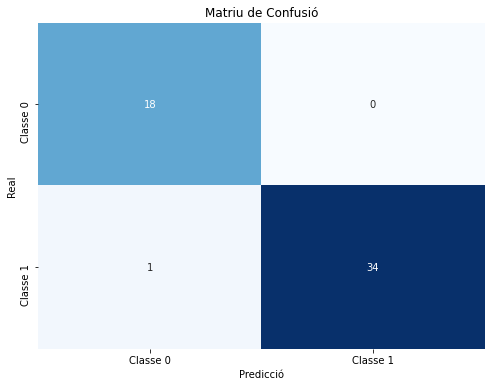

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.97      0.99        35

    accuracy                           0.98        53
   macro avg       0.97      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53



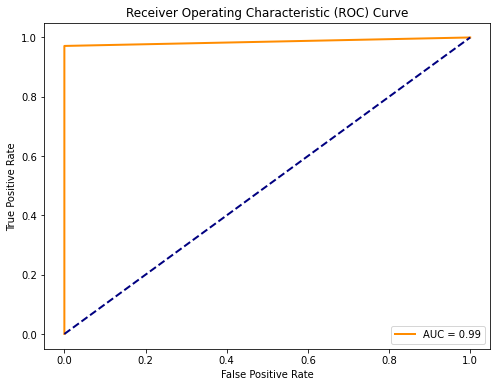

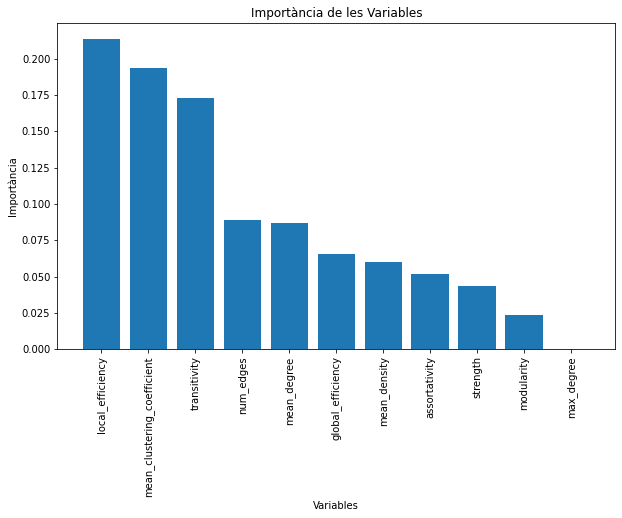

In [21]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

# Se definen las columnas a seleccionar.
list_significative_metrics = list(list_bonferroni_correction.keys())

# Se obtienen los datos de X y Y.
X_selected_cols = df[list_significative_metrics]
y = df['controls_ms']


# Divide data into Train and Testing set.
X_train, X_test, y_train, y_test = train_test_split(X_selected_cols, y, test_size=0.2, random_state=42)

# RANDOM FOREST CLASSIFIER
# Create a Random Forest Classifier model.
model_RFC = RandomForestClassifier(random_state=42)

# Train the model using training data.
model_RFC.fit(X_train, y_train)

# Predict using Testing data.
y_pred = model_RFC.predict(X_test)

# Evaluate the model RFC.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Roc Curve
# Calcula la corba ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Dibuixa la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Obtenim la importancia de cada variable obtinguda pel model RFC.
importancia = model_RFC.feature_importances_

# Ordenem les importàncies i les variables corresponents.
indexes = np.argsort(importancia)[::-1]
feature_names = [list_significative_metrics[i] for i in range(X_selected_cols.shape[1])]

# Plot de la importància de cada variable.
plt.figure(figsize=(10, 6))
plt.bar(range(X_selected_cols.shape[1]), importancia[indexes], align='center')
plt.xticks(range(X_selected_cols.shape[1]), [feature_names[i] for i in indexes], rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importància')
plt.title('Importància de les Variables')
plt.show()

* **Global: Support Vector Machine (SVM)**

Training set - Features: (212, 11), Labels: (212,)
Testing set - Features: (53, 11) Labels: (53,)


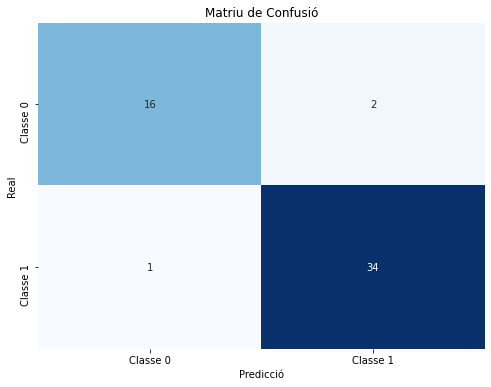

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.94      0.97      0.96        35

    accuracy                           0.94        53
   macro avg       0.94      0.93      0.94        53
weighted avg       0.94      0.94      0.94        53



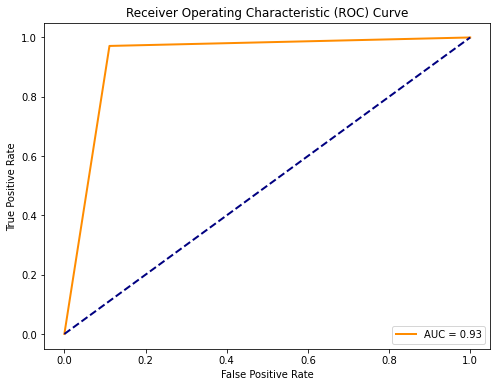

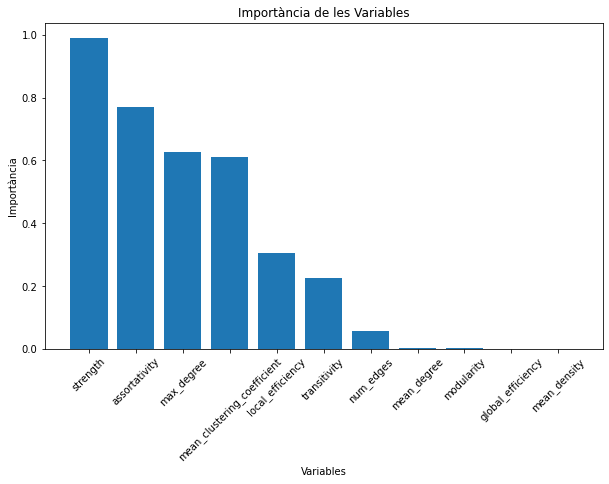

In [22]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(X_selected_cols, y, test_size=0.2, random_state=42)

print(f"Training set - Features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape} Labels: {y_test.shape}")

# Suppot Vector Machine (SVM).
# Creem el model de Suppor vector Machine.
model_SVM = SVC(kernel='linear')

# Entrenem el model utilitzant dades d'entrenament.
model_SVM.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_SVM.predict(X_test)

# Evaluem el model.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Obtenim la importancia de cada variable obtinguda pel model.
importancia = np.abs(model_SVM.coef_[0])

# Ordenem les importàncies i les variables corresponents.
indexes = np.argsort(importancia)[::-1]
feature_names = [list_significative_metrics[i] for i in range(X_selected_cols.shape[1])]

# Plot de la importància de cada variable.
plt.figure(figsize=(10, 6))
plt.bar(range(X_selected_cols.shape[1]), importancia[indexes], align='center')
plt.xticks(range(X_selected_cols.shape[1]), [feature_names[i] for i in indexes], rotation=45)
plt.xlabel('Variables')
plt.ylabel('Importància')
plt.title('Importància de les Variables')
plt.show()


* **Global: KNN**

Training set - Features: (212, 11), Labels: (212,)
Testing set - Features: (53, 11) Labels: (53,)


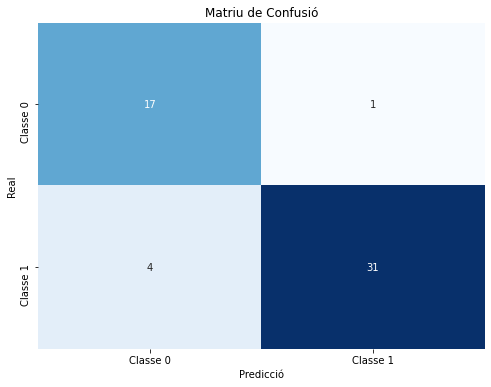

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.97      0.89      0.93        35

    accuracy                           0.91        53
   macro avg       0.89      0.92      0.90        53
weighted avg       0.91      0.91      0.91        53



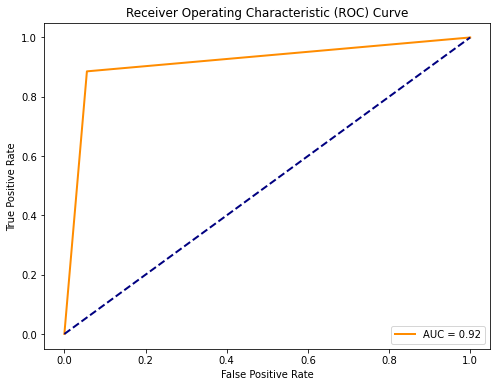

In [23]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier


# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(X_selected_cols, y, test_size=0.2, random_state=42)

print(f"Training set - Features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape} Labels: {y_test.shape}")

# KNN
# Se crea el modelo KNN.
model_KNN = KNeighborsClassifier(n_neighbors=2)

# Entrenem el model utilitzant dades d'entrenament.
model_KNN.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_KNN.predict(X_test)

# Evaluem el model KNN.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


* **Global: Logistic Regression**

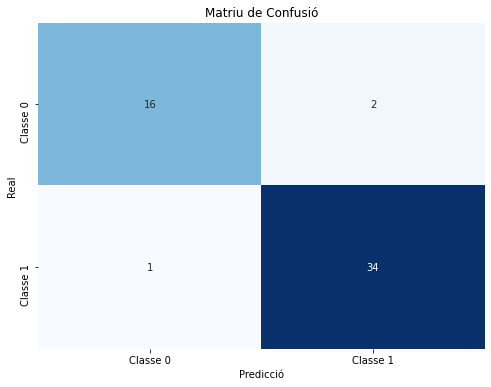

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.94      0.97      0.96        35

    accuracy                           0.94        53
   macro avg       0.94      0.93      0.94        53
weighted avg       0.94      0.94      0.94        53



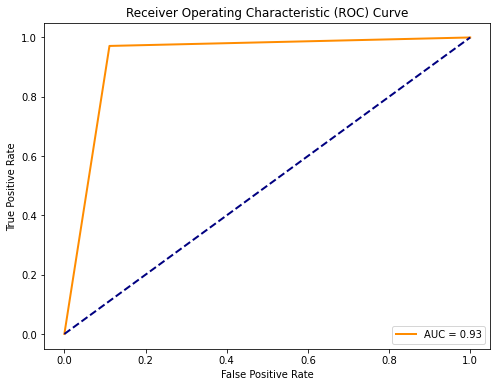

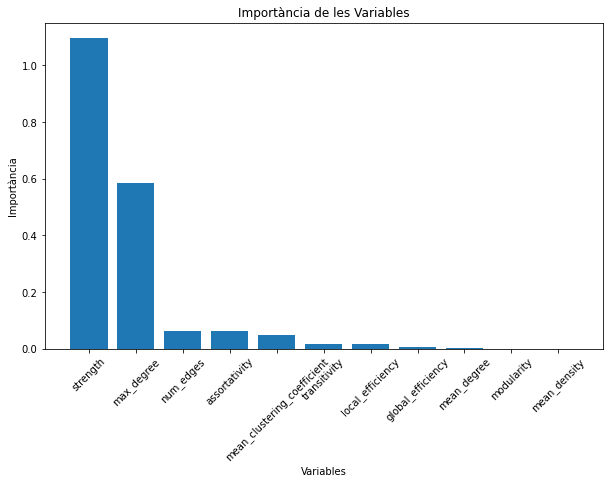

In [24]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression


# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(X_selected_cols, y, test_size=0.2, random_state=42)

# Logistic Regression
# Se crea el modelo Logistic Regression.
model_LR = LogisticRegression()

# Entrenem el model utilitzant dades d'entrenament.
model_LR.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_LR.predict(X_test)

# Evaluem el model Logistic Regression.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Obtenim la importancia de cada variable obtinguda pel model.
importancia = np.abs(model_LR.coef_[0])

# Ordenem les importàncies i les variables corresponents.
indexes = np.argsort(importancia)[::-1]
feature_names = [list_significative_metrics[i] for i in range(X_selected_cols.shape[1])]

# Plot de la importància de cada variable.
plt.figure(figsize=(10, 6))
plt.bar(range(X_selected_cols.shape[1]), importancia[indexes], align='center')
plt.xticks(range(X_selected_cols.shape[1]), [feature_names[i] for i in indexes], rotation=45)
plt.xlabel('Variables')
plt.ylabel('Importància')
plt.title('Importància de les Variables')
plt.show()


* **Global: Gaussian Naive Bayes (GNB)**

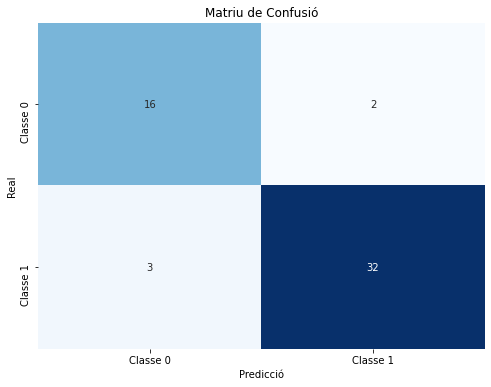

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.94      0.91      0.93        35

    accuracy                           0.91        53
   macro avg       0.89      0.90      0.90        53
weighted avg       0.91      0.91      0.91        53



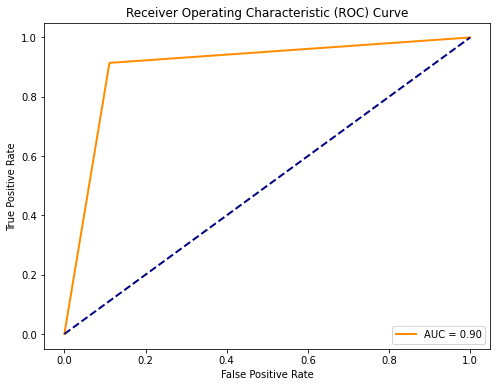

In [25]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB


# Dividim les dades en Train i test.
X_train, X_test, y_train, y_test = train_test_split(X_selected_cols, y, test_size=0.2, random_state=42)

# Gaussian Naive Bayes
# Se crea el modelo Gaussian Naive Bayes.
model_GNB = GaussianNB()

# Entrenem el model utilitzant dades d'entrenament.
model_GNB.fit(X_train, y_train)

# Duem a terme una predicció amb les dades de Test.
y_pred = model_GNB.predict(X_test)

# Evaluem el model Gaussian Naive Bayes.
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Matriu de Confusió.
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Matriu de confusió.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

# Show results.
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# Calculem la curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
